In [1]:
%matplotlib inline

import pandas as pd

from pyspark.sql import SQLContext
from pyspark import SparkContext

## Load Data to spark DataFrame
#### load csv files into spark DataFrames. Then cache the training data in memory for quick, repeatly accessing.

In [2]:
sc = SparkContext()
SqlContext = SQLContext(sc)

df_train = SqlContext.read.load('./data/churn-bigml-80.csv', 
                                format='com.databricks.spark.csv', 
                                header='true', 
                                inferSchema='true')
df_test = SqlContext.read.load('./data/churn-bigml-20.csv', 
                               format='com.databricks.spark.csv', 
                               header='true', 
                               inferSchema='true')
df_train.cache()

DataFrame[State: string, Account length: int, Area code: int, International plan: string, Voice mail plan: string, Number vmail messages: int, Total day minutes: double, Total day calls: int, Total day charge: double, Total eve minutes: double, Total eve calls: int, Total eve charge: double, Total night minutes: double, Total night calls: int, Total night charge: double, Total intl minutes: double, Total intl calls: int, Total intl charge: double, Customer service calls: int, Churn: boolean]

## Prepare Data
### check Nan values for each column
#### print the schema of the sets and find the count of Null and Nan values for each column.

In [35]:
df_train.printSchema()

from pyspark.sql.functions import isnan, when, count, col

print(list(zip([c for c in df_train.columns], [df_train.filter(df_train[c].isNull()).count() for c in df_train.columns])))
# print(df_train.filter(df_train['Voice mail plan'].isNull()).count())
# print(df_train.filter(df_train.Churn.isNull()).count())

root
 |-- Account length: integer (nullable = true)
 |-- International plan: double (nullable = true)
 |-- Voice mail plan: double (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: double (nullable = true)

[('Account length', 0), ('International plan', 0), ('Voice mail plan', 0), ('Number vmail messages', 0), ('Total day minutes', 0), ('Total day calls', 0), ('Total eve minutes', 0), ('Total eve calls', 0), ('Total night minutes', 0), ('Total night calls', 0), ('Total intl minutes', 0), ('Total intl calls', 0),

#### Use pandas to show data

In [7]:
pd.DataFrame(df_train.take(5),columns=df_train.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Summary statistics
#### The describe() function performs summary statistics calculations on all numeric columns, and returns them as a DataFrame.

In [8]:
df_train.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
State,2666,None,None,AK,WY
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
International plan,2666,None,None,No,Yes
Voice mail plan,2666,None,None,No,Yes
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64


### correlations between features
Find correlations by generating scatter plots of them.
For the Pandas workload, we don't want to pull the entire data set into the Spark driver, as that might exhaust the available RAM and throw an out-of-memory exception. Instead, we'll randomly sample a portion of the data (say 10%) to get a rough idea of how it looks.

In [9]:
df_train.dtypes
numeric_features = [t[0] for t in df_train.dtypes if t[1]=='int' or t[1]=='double']
numeric_features

['Account length',
 'Area code',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls']

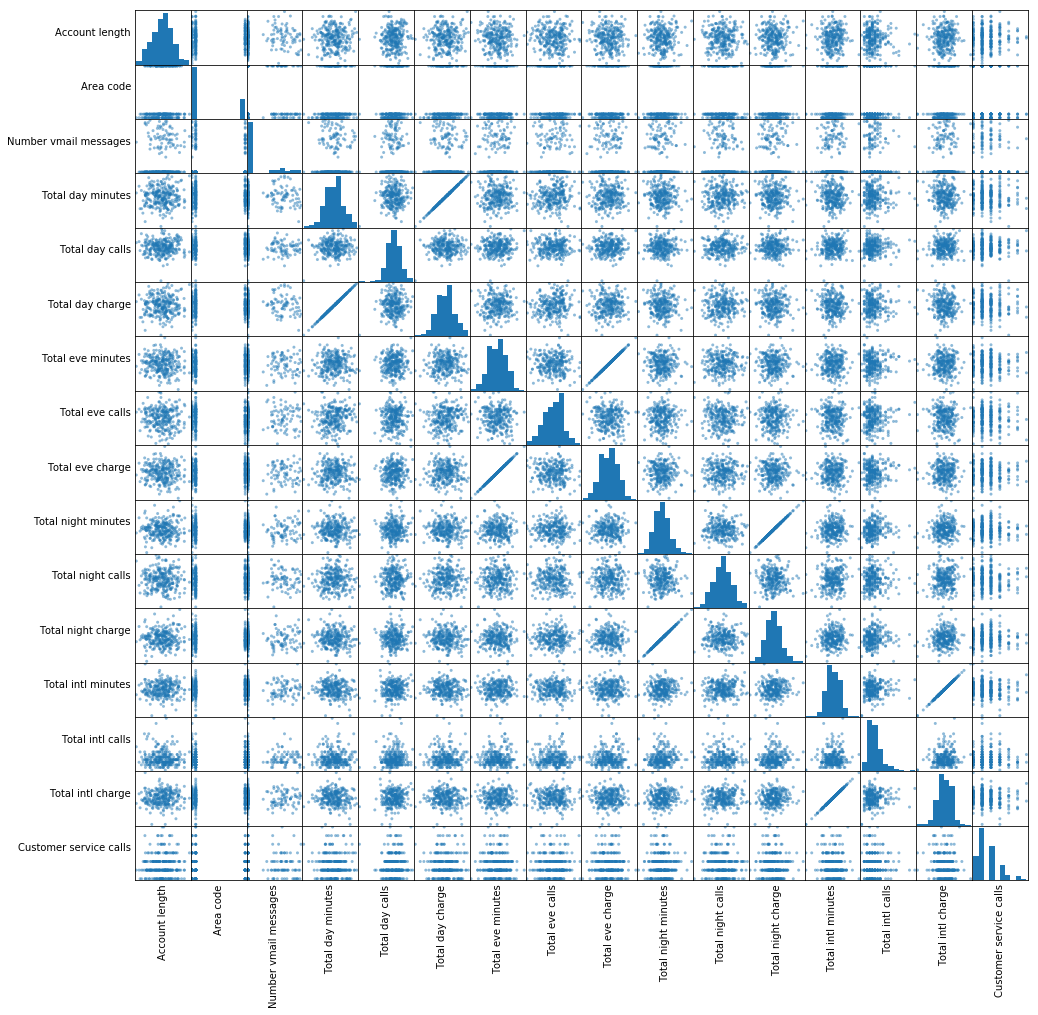

In [10]:
#sample and get 10% data
sampled_data = df_train.select(numeric_features).sample(False, 0.1).toPandas()#False:without replacement
#generate scatter plots of them
axs = pd.plotting.scatter_matrix(sampled_data,figsize=(16,16))
#change the lables' rotations in x&y axis
n = len(numeric_features)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    u = axs[n-1, i]
    u.xaxis.label.set_rotation(90)
    u.set_xticks(())

#### from the plotting result, we can find that (total day minutes, total day charge), (total eve minutes, total eve charge), (total night minutes, total night charge), (total intl minutes, total intl charge) are highly correlated. So we need to remove one of each pair.

### remove the correlated data along with (area code, state), map the string to binary num

In [11]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import UserDefinedFunction

binary_map = {'Yes':1.0, 'No':0.0, True:1.0, False:0.0}
toNum = UserDefinedFunction(lambda k: binary_map[k], DoubleType())

df_train = df_train.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('Churn', toNum(df_train['Churn'])) \
    .withColumn('International plan', toNum(df_train['International plan'])) \
    .withColumn('Voice mail plan', toNum(df_train['Voice mail plan'])).cache()

df_test = df_test.drop('State').drop('Area code').\
            drop('Total day charge').drop('Total eve charge').\
            drop('Total night charge').drop('Total intl charge').\
            withColumn('International plan', toNum(df_test['International plan'])).\
            withColumn('Voice mail plan', toNum(df_test['Voice mail plan'])).\
            withColumn('Churn', toNum(df_test['Churn'])).cache()
            
pd.DataFrame(df_train.take(2), columns=df_train.columns)

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn
0,128,0.0,1.0,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0.0
1,107,0.0,1.0,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0.0


## Train model using MLlib package
MLlib classifiers and regressors require data sets in a format of rows of type LabeledPoint

In [12]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.regression import LabeledPoint

In [13]:
#separates row labels and feature lists and split training data into training and validating.
def labelData(data):
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

train_data, valid_data = labelData(df_train).randomSplit([0.8, 0.2])

print(train_data.toDF().take(2))

# fit training data to decision tree model.
model = DecisionTree.trainClassifier(train_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

print(model.toDebugString())
train_data.toDF()

[Row(features=DenseVector([128.0, 0.0, 1.0, 25.0, 265.1, 110.0, 197.4, 99.0, 244.7, 91.0, 10.0, 3.0, 1.0]), label=0.0), Row(features=DenseVector([107.0, 0.0, 1.0, 26.0, 161.6, 123.0, 195.5, 103.0, 254.4, 103.0, 13.7, 3.0, 1.0]), label=0.0)]
DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 4 <= 262.79999999999995)
   If (feature 12 <= 3.5)
    Predict: 0.0
   Else (feature 12 > 3.5)
    Predict: 1.0
  Else (feature 4 > 262.79999999999995)
   If (feature 2 in {1.0})
    Predict: 0.0
   Else (feature 2 not in {1.0})
    Predict: 1.0



DataFrame[features: vector, label: double]

## Evaluate model using MLlib package
Use MLlib's MulticlassMetrics() for the model evaluation, which takes rows of (prediction, label) tuples as input. It provides metrics such as precision, recall, F1 score and confusion matrix, which have been bundled for printing with the custom printMetrics() function.

In [14]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [15]:
print(train_data.toDF().take(2)[0].features)

DenseVector([128.0, 0.0, 1.0, 25.0, 265.1, 110.0, 197.4, 99.0, 244.7, 91.0, 10.0, 3.0, 1.0])

In [16]:
def getpredictLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda row: row.features))
    return predictions.zip(test_data.map(lambda row: row.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Precision of True ', metrics.precision(1))
    print('Precision of False', metrics.precision(0))
    print('Recall of True    ', metrics.recall(1))
    print('Recall of False   ', metrics.recall(0))
    print('F-1 Score         ', metrics.fMeasure())
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
    
predictions_and_labels = getpredictLabels(model, valid_data)
printMetrics(predictions_and_labels)

Precision of True  0.5294117647058824
Precision of False 0.8972746331236897
Recall of True     0.35526315789473684
Recall of False    0.9469026548672567
F-1 Score          0.8617424242424242
Confusion Matrix
 [[428.  24.]
 [ 49.  27.]]


#### We find that Precision of False and Recall of False are high, but precision of true and recall of true are low. However, business decisions made using these predictions will be used to retain the customers most likely to leave, not those who are likely to stay. Thus, we need to ensure that our model is sensitive to the Churn=True samples.

In [17]:
df_train.groupBy('Churn').count().toPandas()

,Churn,count
0,0.0,2278
1,1.0,388


### build a new model using the evenly distributed data set

In [18]:
stratified_CV_data = df_train.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()
print(stratified_CV_data.groupby('Churn').count().toPandas())

training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])
model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)
predictions_and_labels = getpredictLabels(model, testing_data)
printMetrics(predictions_and_labels)

   Churn  count
0    0.0    404
1    1.0    388
Precision of True  0.8431372549019608
Precision of False 0.6476190476190476
Recall of True     0.5375
Recall of False    0.8947368421052632
F-1 Score          0.7115384615384616
Confusion Matrix
 [[68.  8.]
 [37. 43.]]


## Cross validation to select the best model using the Spark ML Package
It provides an API for pipelining data transformers, estimators and model selectors. 
It perform cross-validation across several decision trees with various maxDepth parameters in order to find the optimal model.

In [19]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [20]:
def vectorizedata(data):
    return data.rdd.map(lambda row: [row[-1], Vectors.dense(row[:-1])]).toDF(['label','features'])

vectorized_data = vectorizedata(stratified_CV_data)
vectorized_data.take(2)

[Row(label=0.0, features=DenseVector([128.0, 0.0, 1.0, 25.0, 265.1, 110.0, 197.4, 99.0, 244.7, 91.0, 10.0, 3.0, 1.0])),
 Row(label=0.0, features=DenseVector([121.0, 0.0, 1.0, 24.0, 218.2, 88.0, 348.5, 108.0, 212.6, 118.0, 7.5, 7.0, 3.0]))]

In [21]:
# understand the dense vectors.
print(stratified_CV_data.take(1)[0][:-1])
print(Vectors.dense(stratified_CV_data.take(1)[0][:-1]))

(128, 0.0, 1.0, 25, 265.1, 110, 197.4, 99, 244.7, 91, 10.0, 3, 1)
[128.0,0.0,1.0,25.0,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0]


In [22]:
#index labels and feature
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel')
featureIndexer = VectorIndexer(inputCol='features',
                               outputCol='indexedFeatures',
                               maxCategories=2)

#Train a Decision Tree model
dtree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

#Chain indexer and tree in a pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dtree])

#hype-parameters to choose
paramGrid = ParamGridBuilder().addGrid(dtree.maxDepth, [2, 3, 4, 5, 6, 7]).build()

#add evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel', predictionCol='prediction', metricName='f1')

#set cross validation
crossVal = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid,
                         evaluator=evaluator, numFolds=10)

#fit the data
CV_model = crossVal.fit(vectorized_data)

#Fetch best model
tree_model = CV_model.bestModel.stages[2]
print(tree_model)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_48d4a1209b698cd78467) of depth 5 with 53 nodes


In [23]:
vectorized_test_data = vectorizedata(df_test)

transformed_data = CV_model.transform(vectorized_test_data)
print(evaluator.getMetricName(), 'accuracy:', evaluator.evaluate(transformed_data))

predictions = transformed_data.select('indexedLabel', 'prediction', 'probability')
predictions.toPandas().head()

f1 accuracy: 0.8646917870468018


,indexedLabel,prediction,probability
0,0.0,0.0,"[0.9003436426116839, 0.09965635738831616]"
1,1.0,1.0,"[0.013157894736842105, 0.9868421052631579]"
2,1.0,1.0,"[0.0, 1.0]"
3,0.0,0.0,"[0.9003436426116839, 0.09965635738831616]"
4,0.0,0.0,"[0.9003436426116839, 0.09965635738831616]"
